In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.5.0


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()
dataset = dataset.dropna()

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'EUROPE', 3: 'JAPAN'})

In [8]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,EUROPE,JAPAN,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

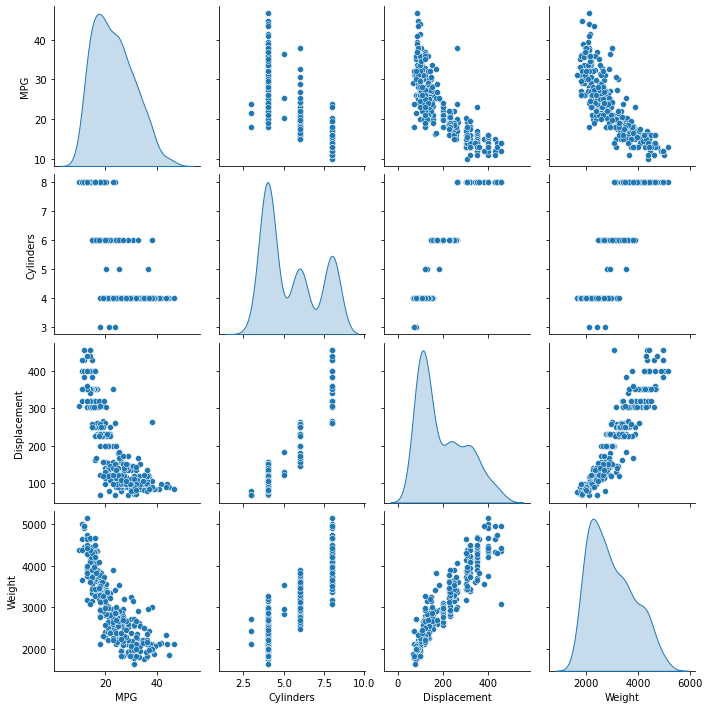

In [10]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
EUROPE,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
JAPAN,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
EUROPE,0.178344,0.383413
JAPAN,0.197452,0.398712
USA,0.624204,0.485101


In [14]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [15]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [16]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
# with np.printoptions(precision=2, suppress=True):
#   print('Horse Power not normalized:', horsepower)
#   print()
#   print('Normalized:', horsepower_normalizer(horsepower).numpy())

In [17]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [18]:
horsepower_model.predict(horsepower[:10])

array([[ 0.594],
       [ 0.335],
       [-1.096],
       [ 0.833],
       [ 0.753],
       [ 0.296],
       [ 0.892],
       [ 0.753],
       [ 0.196],
       [ 0.335]], dtype=float32)

In [19]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [20]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1.39 s, sys: 97 ms, total: 1.49 s
Wall time: 1.29 s


In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.807021,4.191600,95
96,3.803911,4.195142,96
97,3.802571,4.190801,97
98,3.802129,4.188761,98
99,3.805651,4.200594,99


In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

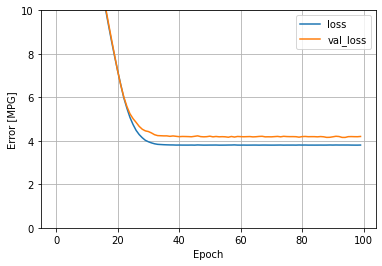

In [23]:
plot_loss(history)

In [24]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [25]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [26]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

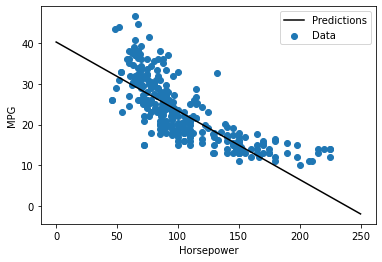

In [27]:
plot_horsepower(x,y)

In [28]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [29]:
linear_model.predict(train_features[:10])

array([[-0.143],
       [ 0.087],
       [ 0.102],
       [ 0.304],
       [-0.594],
       [-0.429],
       [-0.769],
       [ 0.091],
       [-0.439],
       [-0.979]], dtype=float32)

In [30]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.129],
       [-0.757],
       [ 0.689],
       [ 0.142],
       [-0.265],
       [ 0.363],
       [-0.221],
       [-0.714],
       [-0.617]], dtype=float32)>

In [31]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [32]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1.47 s, sys: 112 ms, total: 1.59 s
Wall time: 1.36 s


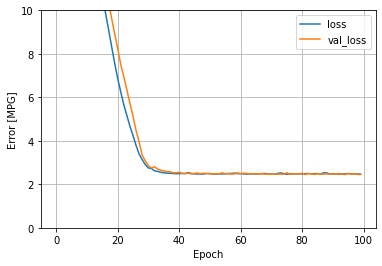

In [33]:
plot_loss(history)

In [34]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [35]:
def plot_linear(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

In [36]:
x = tf.linspace(0.0, 250, 251)
y = linear_model.predict(x)

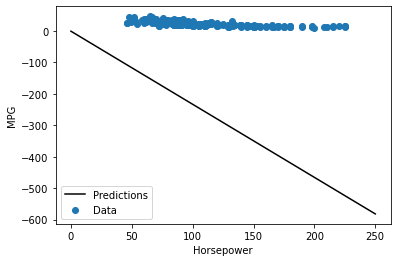

In [37]:
plot_linear(x,y)

In [38]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [39]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [40]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.59 s, sys: 476 ms, total: 3.06 s
Wall time: 2.23 s


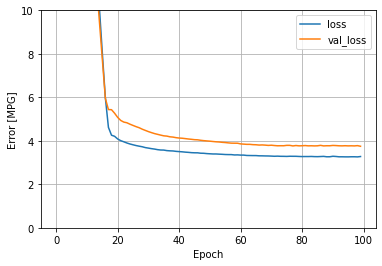

In [42]:
plot_loss(history)

In [43]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

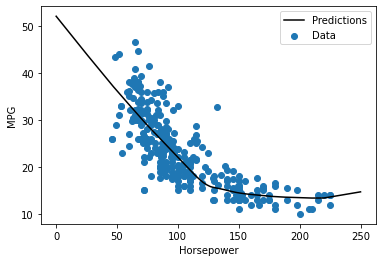

In [44]:
plot_horsepower(x, y)

In [45]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [46]:
print(test_results)

{'horsepower_model': 3.6451823711395264, 'linear_model': 2.490191698074341, 'dnn_horsepower_model': 2.9267561435699463}


In [47]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [48]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.59 s, sys: 505 ms, total: 3.1 s
Wall time: 2.25 s


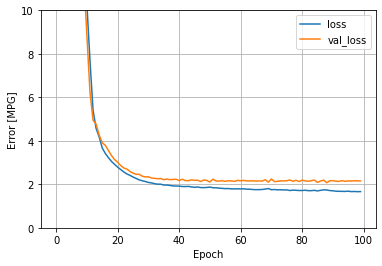

In [49]:
plot_loss(history)

In [50]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [51]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.645182
linear_model,2.490192
dnn_horsepower_model,2.926756
dnn_model,1.624741


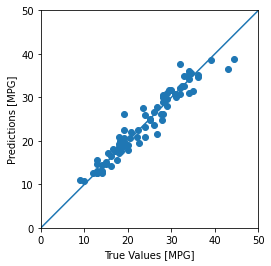

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

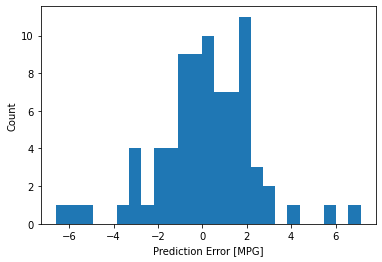

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')